In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy

---
# VIDEO: Mean-smooth a time series
---

[0.00000000e+00 5.00166722e-03 1.00033344e-02 ... 1.49899967e+01
 1.49949983e+01 1.50000000e+01]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[0.4110581  0.57981396 0.05657394 0.5633769  0.16811232 0.54925745
 0.03360333 0.38613038 0.11798622 0.57547715 0.46887067 0.19454099
 0.67243564 0.7878651  0.61092792]


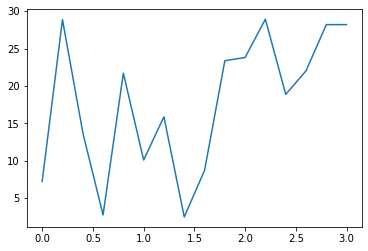

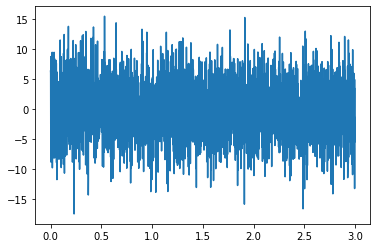

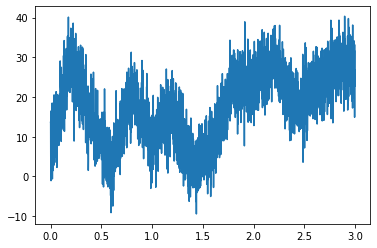

range of filtsig = range(50, 2949)


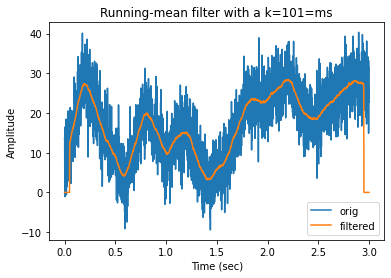

In [3]:
srate = 1000
time = np.arange(0,3,1/srate) # 3 seconds
n = len(time)
p = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl = np.interp(np.linspace(0,p,n), np.arange(0,p), np.random.rand(p)*30) # interpolate y = interp(x, xp, fp) where x is the coordinates for interpolation, xp are the poles, fp are the y-coordinates of the xp poles. Will return y which is the same length as x
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

print(np.linspace(0,p,n))
print(np.arange(0,p))
print(np.random.rand(p))

# Plotting for debugging
plt.plot(time, ampl)
plt.show()
plt.plot(time, noise)
plt.show()
plt.plot(time, signal)
plt.show()

# initialize filtered signal vector
filtsig = np.zeros(n)

# implement the running mean filter
k = 50 # filter window is actually k*2+1 
print(f"range of filtsig = {range(k, n-k-1)}")
for i in range(k,n-k-1):
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k])

# compute window size in ms
windowsize = 1000 * (k*2+1) / srate

# plot the noisy and filtered signals
plt.plot(time, signal, label='orig')
plt.plot(time, filtsig, label='filtered')

plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d=ms' %windowsize)

plt.show()



---
# VIDEO: Gaussian-smooth a time series
---

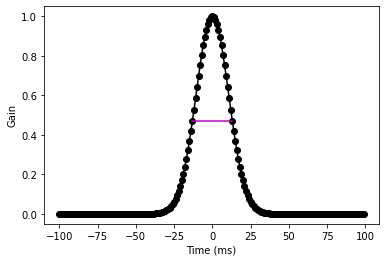

In [4]:
# create signal
srate = 1000 # Hz
time = np.arange(0,3,1/srate)
n = len(time)
p = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl = np.interp(linspace(1,p,n), np.arange(0,p), np.random.rand(p)*30)
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

## Create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in ms

# normalized time vector in ms 
k = 100
gtime = 1000*np.arange(-k,k) / srate

# create Gaussian window 
gauswin = np.exp(-(4*np.log(2)*gtime**2) / fwhm**2)

# compute empirical FWHM 
pstPeakHalf = k+np.argmin((gauswin[k:]-0.5)**2) # find the index in gaussian window corresponding to half the maximum value, then square it because there are positive and negative values 
prePeakHalf = np.argmin((gauswin-0.5)**2) # do the same thing but for the first half of the gaussian window before the peak 

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# show the Gaussian 
plt.plot(gtime, gauswin, 'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]], [gauswin[prePeakHalf], gauswin[pstPeakHalf]], 'm')

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()


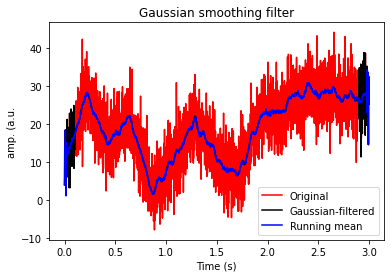

In [5]:
## implement the filter

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal)

# implement the gaussian window filter
for i in range(k+1, n-k-1):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum(signal[i-k:i+k] * gauswin)

# plot
plt.plot(time, signal,  'r', label='Original')
plt.plot(time, filtsigG, 'k', label='Gaussian-filtered')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.')
plt.legend()
plt.title('Gaussian smoothing filter')

## for comparison, plot mean smoothing filter

# initialize filtered signal vector 
filtsigMean = copy.deepcopy(signal)

# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 20 # filter window is actually mk*2+1
for i in range(mk+1, n-mk-1):
    # each point is the average of k surrounding points
    filtsigMean[i] = mean(signal[i-mk:i+mk])
plt.plot(time, filtsigMean, 'b', label='Running mean')
plt.legend()
plt.show()

---
# VIDEO: Gaussian-smooth a spike time series
---

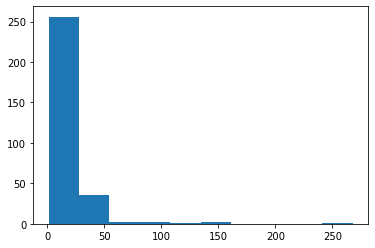

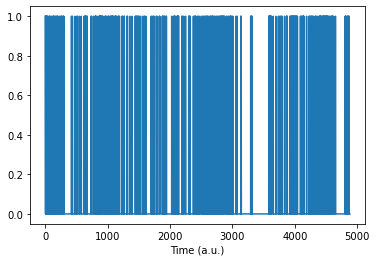

In [7]:
## generate time series of random spikes

# number of spikes
n = 300 

# inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp(np.random.randn(n))*10) # this generates an exponential distribution where there is are a lot of short interspike intervals but less longer interspike intervals 
plt.hist(isi)
plt.show()

# generate spike time series
spikets = np.zeros(int(sum(isi))) # add up all the interspike intervals to get the total length of the time vector

for i in range(0, n):
    spikets[int(np.sum(isi[0:i]))] = 1 # loop through each interspike interval value and set to 1. Add them up one by one as you go through the loop to get the right spike times

# plot
plt.plot(spikets)
plt.xlabel('Time (a.u.)')
plt.show()

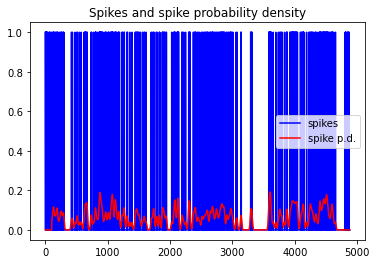

In [8]:
## create and implement Gaussian window

# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in points

# normalized time vector in ms
k = 100
gtime = np.arange(-k,k)

# create Gaussian window
gauswin = np.exp(-(4*log(2)*gtime**2) / fwhm**2)
gauswin = gauswin / np.sum(gauswin)

# initialize filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement the weighted running mean filter
for i in range(k+1, len(spikets)-k-1):
    filtsigG[i] = np.sum(spikets[i-k:i+k] * gauswin)

# plot the filtered signal (spike probability density)
plt.plot(spikets, 'b', label='spikes')
plt.plot(filtsigG, 'r', label='spike p.d.')
plt.legend()
plt.title('Spikes and spike probability density')
plt.show()

---
# VIDEO: Denoising via TKEO
---

In [ ]:
# import data
emgdata = sio.loadmat('emg4TKEO.mat')

# extract needed variables
emgtime = emgdata['emgtime'][0]
emg = emgdata['emg'][0]

# initialize filtered signal
emgf = copy.deepcopy(emg)

# the loop version for interpretability
for i in range(1, len(emgf)-1):
    emgh[i] = emg[i]**2 - emg[i-1]*emg[i+1]


# the vectorized version for speed and elegance
emgf2 = copy.deepcopy(emg)
emgf2[1:-1] = emg[i:-1]**2 - emg[0:-2]*emg[2:] # three vectors, main vector gets squared from 1 to end-1 and you subtract the product of the vector that starts at 0 and ends at end-2 multiplied by the time point ahead which starts at 2 and ends with the last time point

## convert both signal to zscore

# find timepoint zero
time0 = np.argmin(emgtime**2)

# convert original EMG to z-score from time-zero
emgZ = (emg-np.mean(emg[0:time0])) / np.std(emg[0:time0])

